<a href="https://www.kaggle.com/code/ibrahimnibrahim/spam-email-classification-f1-0-99?scriptVersionId=244285356" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-classification-dataset/combined_data.csv


In [2]:
df=pd.read_csv('/kaggle/input/email-spam-classification-dataset/combined_data.csv')
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


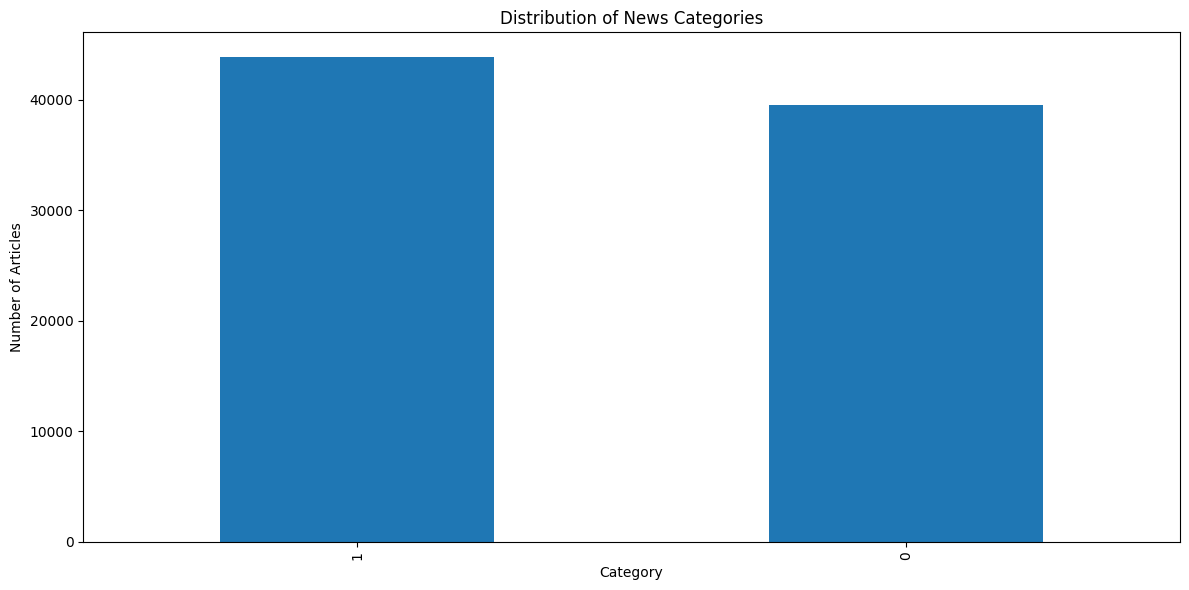

In [3]:
import matplotlib.pyplot as plt
# Count unique categories
category_counts = df['label'].value_counts()

# Plot the category distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
import nltk
from nltk.corpus import stopwords

text=df['text'].apply(lambda x: str(x).lower().split())
labels=df['label']

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

text=text.apply(lambda x : ' '.join([word for word in x if word not in stop_words]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import tensorflow as tf

vectorized_layer=tf.keras.layers.TextVectorization(ragged=True,max_tokens=20000)
vectorized_layer.adapt(text)

sequence=vectorized_layer(text)

padded=tf.keras.utils.pad_sequences(
    sequence.numpy(),
    maxlen=100,
    padding='pre',
    truncating='pre',
)

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(padded, labels, test_size=0.2, random_state=101)

In [7]:
text_train=tf.data.Dataset.from_tensor_slices(text_train)
text_test=tf.data.Dataset.from_tensor_slices(text_test)

labels_train=tf.data.Dataset.from_tensor_slices(labels_train)
labels_test=tf.data.Dataset.from_tensor_slices(labels_test)

train_dataset=tf.data.Dataset.zip(text_train,labels_train)
test_dataset=tf.data.Dataset.zip(text_test,labels_test)

In [8]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE).batch(64)
test_dataset=test_dataset.cache().prefetch(tf.data.AUTOTUNE).batch(64)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Embedding(input_dim=20000, output_dim=128,),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 98, 80)              │          54,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 98, 80)              │          38,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,007,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,709,633 (17.97 MB)

 Trainable params: 4,709,633 (17.97 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

In [12]:
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset,callbacks=[es,])

Epoch 1/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.9505 - loss: 0.1151 - val_accuracy: 0.9845 - val_loss: 0.0442
Epoch 2/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9866 - val_loss: 0.0564
Epoch 3/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9975 - loss: 0.0072 - val_accuracy: 0.9871 - val_loss: 0.0591
Epoch 4/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9978 - loss: 0.0061 - val_accuracy: 0.9854 - val_loss: 0.0730
Epoch 5/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9856 - val_loss: 0.0697
Epoch 6/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9859 - val_loss: 0.0784
Epoch 7/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9862 - val_loss: 0.0764
Epoch 8/15
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9995 -

In [13]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)
labels_test_np = np.concatenate([y for x, y in test_dataset], axis=0) 

accuracy = accuracy_score(labels_test_np, y_pred)  
report = classification_report(labels_test_np, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%\n')
print(report)

261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 98.71%

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7883
           1       0.98      0.99      0.99      8807

    accuracy                           0.99     16690
   macro avg       0.99      0.99      0.99     16690
weighted avg       0.99      0.99      0.99     16690



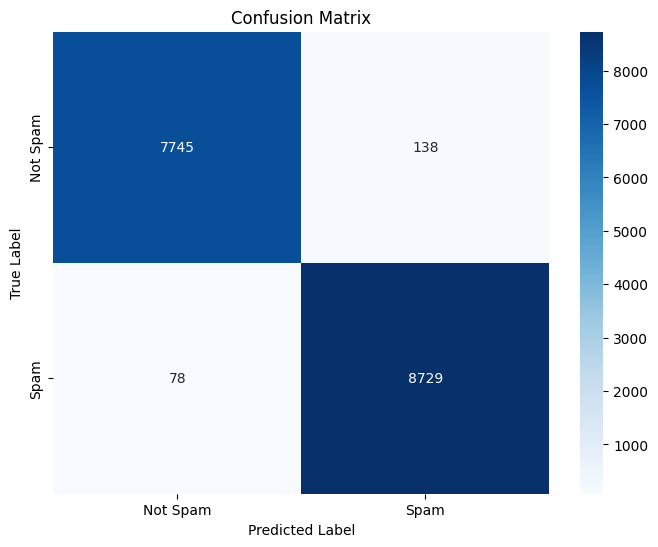

In [14]:
import seaborn as sns


# Assuming y_pred and labels_test_np are your predictions and true labels
cm = confusion_matrix(labels_test_np, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()